<a href="https://colab.research.google.com/github/salmanromeo/CS_5683_Big_Data_Analytics/blob/main/Assignment_2_1_Collaborative_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment Tasks**

In this assignment, we will get hands-on with collaborative recommender systems method for making movie recommendations. We will create a program module for data pre-processing, develop a program to extract collaborative recommendations, and evaluate the method's performance using the Root Mean Squared Error (RMSE) metric.

**Task-1: Data pre-processing**



1.   Download the data and develop a Python program to store the training and test samples in appropriate data structures



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Store training data
file_path = '/content/sample_data/Train_ratings.txt'

# Define the column names
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the text file using '::' as the delimiter
df_train = pd.read_csv(file_path, sep='::', engine='python', header=None, names=column_names)

# Split train data into train and test
train_data, test_data = train_test_split(df_train, test_size=0.5, random_state=42)

train_data.to_csv('train_new.csv', index=False)
test_data.to_csv('test_new.csv', index=False)

In [2]:
df_train = train_data.head()
df_train.head()

,user_id,item_id,rating,timestamp
237915,5894,1240,3,957463537
95859,2323,1240,4,974518416
234144,5803,3261,1,957995261
73825,1804,2600,1,974698992
65840,1639,781,4,975142879


In [3]:
df_test = test_data.head()
df_test.head()

,user_id,item_id,rating,timestamp
189255,4652,1957,5,963950073
174285,4296,2688,3,965270362
107425,2713,2628,3,973286706
48931,1231,1240,5,974919841
217085,5394,1454,4,981004162


2.   We will create a utility matrix with the available ratings from the training set. It is okay to create large-scale utility matrix for this Assignment.

In [4]:
# Create a utility matrix
utility_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating')

# Fill missing ratings with 0 or NaN
utility_matrix = utility_matrix.fillna(0)

# Display the utility matrix
print(utility_matrix.head())

item_id  3     12    19    20    21    25    31    35    40    43    ...  \
user_id                                                              ...   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2         0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  3914  3915  3917  3926  3937  3939  3942  3943  3946  3951  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0


3.   To avoid discrepancy with cosine similarity, we will normalize the data using pearson correlation function $R_{x_{i}}=R_{x_{i}} - {R̄}_i$, where $R_{x_{i}}$ is the rating given by user '$x$' to a movie '$i$', and $R_{i}$ is the average rating for the movie '$i$'







In [5]:
# Normalize the utility matrix by subtracting the mean rating for each movie
movie_means = utility_matrix.mean(axis=0)
normalized_matrix = utility_matrix.subtract(movie_means, axis=1)

# Replace NaN values with 0 after normalization
normalized_matrix = normalized_matrix.fillna(0)

# Display normalized matrix
print(normalized_matrix.head())

item_id      3         12        19        20        21        25        31    \
user_id                                                                         
1       -0.124624 -0.035416 -0.078517 -0.034414 -0.417975 -0.283996 -0.034748   
2       -0.124624 -0.035416 -0.078517 -0.034414  0.582025 -0.283996 -0.034748   
3       -0.124624 -0.035416 -0.078517 -0.034414 -0.417975 -0.283996 -0.034748   
4       -0.124624 -0.035416 -0.078517 -0.034414 -0.417975 -0.283996 -0.034748   
5       -0.124624 -0.035416 -0.078517 -0.034414 -0.417975 -0.283996 -0.034748   

item_id      35        40        43    ...      3914      3915      3917  \
user_id                                ...                                 
1       -0.018877 -0.008854 -0.046776  ... -0.017541 -0.040094 -0.073839   
2       -0.018877 -0.008854 -0.046776  ... -0.017541 -0.040094 -0.073839   
3       -0.018877 -0.008854 -0.046776  ... -0.017541 -0.040094 -0.073839   
4       -0.018877 -0.008854 -0.046776  ... -0.017541

**Task-2: Producing recommendations**


1.   For each user '$x$' and movie '$i$', given in the test set, find the similarity of movie '$i$' with all the movies rated by user '$x$'. We will use the cosine similarity to find the similarity ('$s_{ij}$') of movies '$i$' and '$j$':
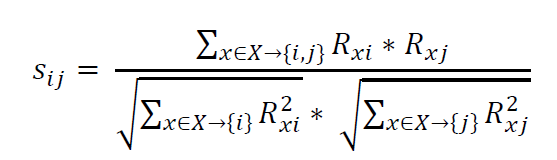

where $𝑥∈𝑋→{𝑖,𝑗}$ is a set of users who rated both movies '$i$' and '$j$', $𝑥∈𝑋→{𝑖}$ is a set of users who rated the movie '$i$' only, and $𝑥∈𝑋→{𝑗}$ is a set of users who rated the movie '$j$' only. We choose the movie '$j$' if and only if the user '$x$' has given a rating to it. NOTE: The normalization used in the similarity equation is computationally intensive, if calculated in each step. Students must find an efficient approach to solve this.

In [ ]:
def cosine_similarity_matrix(normalized_matrix):
    # Number of movies
    num_movies = normalized_matrix.shape[1]

    # Initialize the similarity matrix
    similarity_matrix = np.zeros((num_movies, num_movies))

    # Compute the cosine similarity for each pair of movies
    for i in range(num_movies):
        for j in range(num_movies):
            if i != j:  # Avoid self-similarity
                users_i = normalized_matrix.iloc[:, i].to_numpy()
                users_j = normalized_matrix.iloc[:, j].to_numpy()

                # Only consider users who rated both movies
                common_users = np.where((users_i != 0) & (users_j != 0))[0]

                if len(common_users) == 0:
                    similarity_matrix[i, j] = 0  # No common users
                    continue

                # Calculate the numerator (dot product of the ratings)
                numerator = np.sum(users_i[common_users] * users_j[common_users])

                # Calculate the denominator (Euclidean norms of the ratings)
                denominator = np.sqrt(np.sum(users_i[common_users]**2)) * np.sqrt(np.sum(users_j[common_users]**2))

                if denominator == 0:
                    similarity_matrix[i, j] = 0  # Avoid division by zero
                else:
                    similarity_matrix[i, j] = numerator / denominator

    return similarity_matrix

# Compute the cosine similarity matrix between all movies
similarity_matrix = cosine_similarity_matrix(normalized_matrix)

# Create a DataFrame for better readability
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=normalized_matrix.columns, columns=normalized_matrix.columns)

# Print the cosine similarity matrix
print(similarity_matrix_df.head())

**Efficient approach**

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix between all movies
similarity_matrix = cosine_similarity(normalized_matrix.T)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=utility_matrix.columns, columns=utility_matrix.columns)

# Print the cosine similarity matrix
print(similarity_matrix_df.head())

item_id      3         12        19        20        21        25        31    \
item_id                                                                         
3        1.000000  0.088655  0.111241  0.073554  0.061918  0.039081  0.083297   
12       0.088655  1.000000  0.141323  0.057977  0.031965 -0.009770  0.057131   
19       0.111241  0.141323  1.000000  0.104051  0.081120  0.031245  0.097386   
20       0.073554  0.057977  0.104051  1.000000  0.093241  0.061991  0.117424   
21       0.061918  0.031965  0.081120  0.093241  1.000000  0.105692  0.044832   

item_id      35        40        43    ...      3914      3915      3917  \
item_id                                ...                                 
3       -0.006355  0.026967  0.003195  ...  0.019597  0.003359  0.053192   
12       0.012572 -0.005236  0.035263  ...  0.037998 -0.003310  0.046122   
19       0.007059 -0.007624  0.025580  ...  0.020145  0.017529  0.014227   
20       0.017339  0.017570  0.003028  ...  0.041096

2. Sort all the similarity values in a descending order and pick the top '$k=5$' movies with their similarity values

In [7]:
# Define the number of top similar movies to retrieve
k = 5

# Create an empty dictionary to store the top k similar movies for each movie
top_k_similar_movies = {}

# Iterate over each movie in the similarity matrix
for movie_id in similarity_matrix_df.columns:
    # Sort the similarity values in descending order and exclude the movie itself (similarity 1.0)
    sorted_similarities = similarity_matrix_df[movie_id].sort_values(ascending=False)

    # Get the top k movies (ignoring the first entry which is the movie itself)
    top_k = sorted_similarities.iloc[1:k+1]

    # Store the top k similar movies and their similarity values in the dictionary
    top_k_similar_movies[movie_id] = top_k

# Display the top 5 similar movies for each movie
for movie_id, similar_movies in top_k_similar_movies.items():
    print(f"\nMovie ID: {movie_id}")
    print(similar_movies)

Streaming output truncated to the last 5000 lines.
325     0.068637
2495    0.033387
1296    0.011908
887    -0.000167
Name: 1532, dtype: float64

Movie ID: 1533
item_id
263     0.321793
3010    0.300831
993     0.232320
652     0.213983
1121    0.200372
Name: 1533, dtype: float64

Movie ID: 1535
item_id
1728    0.189314
2214    0.163351
1430    0.163351
776     0.163351
2721    0.145163
Name: 1535, dtype: float64

Movie ID: 1537
item_id
52      0.119246
1734    0.116614
1446    0.115326
2357    0.111811
265     0.111023
Name: 1537, dtype: float64

Movie ID: 1538
item_id
462     0.204976
771     0.199609
1703    0.155696
1772    0.139181
354     0.135577
Name: 1538, dtype: float64

Movie ID: 1542
item_id
1683    0.153694
1684    0.148799
994     0.146625
357     0.142170
2179    0.139411
Name: 1542, dtype: float64

Movie ID: 1547
item_id
2242    0.273108
1877    0.266396
993     0.216689
3575    0.203145
2979    0.176052
Name: 1547, dtype: float64

Movie ID: 1549
item_id
1767    0.2621

3. Predict the rating of a given test user '$x$' and a given test movie '$i$' $̃R_{xi}$ with the prediction formula:
$R_{xi}=(∑_{j∈N} s_{ij} * R_{xj})/(∑_{j∈N} s_{ij})$
where $N$ is a set of '$k$' items

In [13]:
def predict_rating(user_id, movie_id, k=5):
    # Check if the user exists in the utility matrix
    if user_id not in utility_matrix.index:
        print(f"User {user_id} not found in the utility matrix.")
        return None

    # Check if the movie exists in the cosine similarity DataFrame
    if movie_id not in similarity_matrix_df.columns:
        print(f"Movie {movie_id} not found in the cosine similarity matrix.")
        return None

    user_ratings = utility_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index

    # Check if the user has rated any movies
    if len(rated_movies) == 0:
        print(f"User {user_id} has not rated any movies.")
        return None

    print("User Ratings: ", user_ratings.head())
    print("Rated Movies: ", rated_movies.tolist())

    # Get the similarities for the target movie
    movie_similarities = similarity_matrix_df[movie_id]
    print("Movie Similarities: ", movie_similarities.head())

    # Filter out movies that the user has rated
    similar_rated_movies = movie_similarities[rated_movies]

    # Check if there are enough similar movies
    if len(similar_rated_movies) == 0:
        print(f"No similar movies found for user {user_id} and movie {movie_id}.")
        return None

    # Sort by similarity and take the top-k most similar movies
    top_k_similar = similar_rated_movies.nlargest(k)

    # Predict the rating using weighted average of top-k similar movies
    top_k_ratings = utility_matrix.loc[user_id, top_k_similar.index]

    # Make sure the denominator is not zero
    if top_k_similar.sum() == 0:
        print(f"Sum of similarities is zero, cannot predict rating for movie {movie_id}.")
        return None

    predicted_rating = np.dot(top_k_similar, top_k_ratings) / top_k_similar.sum()

    return predicted_rating

# Test the function with a valid user_id and movie_id from the dataset
predicted_rating = predict_rating(user_id=5, movie_id=1022, k=5)  # Replace with actual IDs
print(f"Predicted Rating: {predicted_rating}")

User Ratings:  item_id
3     0.0
12    0.0
19    0.0
20    0.0
21    0.0
Name: 5, dtype: float64
Rated Movies:  [162, 265, 1046, 1093, 1175, 1485, 1527, 1535, 1683, 1684, 1759, 1921, 2571, 2683, 2770, 3006, 3079]
Movie Similarities:  item_id
3     0.072986
12    0.020869
19    0.057694
20    0.034262
21    0.013259
Name: 1022, dtype: float64
Predicted Rating: 3.4928562772556977


**Task-3: Prediction evaluation**

Obtain predictions for all test instances in a Python list and evaluate the recommendation performance using RMSE module.

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# RMSE function
def RMSE(y_actual, y_predicted):
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    return round(rms, 4)

# Lists to store actual and predicted ratings
actual_ratings = []
predicted_ratings = []

# Obtain predictions for all test instances
for index, row in test_data.iterrows():
    user_id = row['user_id']
    movie_id = row['item_id']
    actual_rating = row['rating']

    predicted_rating = predict_rating(user_id, movie_id, k=5)  # Get predicted rating
    if predicted_rating is not None:  # Ensure prediction was successful
        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

# Evaluate the recommendation performance using RMSE
if actual_ratings and predicted_ratings:  # Ensure both lists have values
    rmse_value = RMSE(actual_ratings, predicted_ratings)
    print(f"RMSE: {rmse_value}")
else:
    print("No predictions were made.")

Streaming output truncated to the last 5000 lines.
19    0.077959
20    0.114187
21    0.138695
Name: 2000, dtype: float64
User Ratings:  item_id
3     0.0
12    0.0
19    0.0
20    0.0
21    0.0
Name: 4411, dtype: float64
Rated Movies:  [35, 43, 45, 73, 222, 246, 357, 457, 500, 534, 595, 608, 718, 745, 858, 911, 918, 924, 994, 1009, 1022, 1025, 1046, 1073, 1083, 1148, 1196, 1230, 1265, 1286, 1296, 1408, 1416, 1422, 1459, 1517, 1535, 1542, 1619, 1665, 1683, 1704, 1721, 1754, 1801, 2005, 2012, 2013, 2100, 2119, 2137, 2160, 2287, 2382, 2383, 2408, 2413, 2436, 2468, 2485, 2529, 2567, 2628, 2648, 2686, 2721, 2792, 2965, 2990, 2993, 3005, 3047, 3061, 3256, 3264, 3396, 3447, 3618, 3638, 3911, 3914]
Movie Similarities:  item_id
3     0.077419
12    0.033387
19    0.102245
20    0.096334
21    0.139160
Name: 349, dtype: float64
User Ratings:  item_id
3     0.0
12    0.0
19    0.0
20    0.0
21    0.0
Name: 4595, dtype: float64
Rated Movies:  [858, 1148, 1206, 2010, 2529, 3702]
Movie Similaritie

**Task-4: Final performance chart**

Experiment your method by varying the values of $k=10, 15,$ and $25$. Report RMSE for each '$k$'

In [20]:
# k values to experiment
k_values = [10, 15, 25]

# Dictionary to store RMSE results for each k
rmse_results = {}

for k in k_values:
    actual_ratings = []
    predicted_ratings = []

    # Obtain predictions for all test instances
    for index, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['item_id']
        actual_rating = row['rating']

        predicted_rating = predict_rating(user_id, movie_id, k=k)  # Get predicted rating
        if predicted_rating is not None:  # Ensure prediction was successful
            actual_ratings.append(actual_rating)
            predicted_ratings.append(predicted_rating)

    # Evaluate the recommendation performance using RMSE
    if actual_ratings and predicted_ratings:  # Ensure both lists have values
        rmse_value = RMSE(actual_ratings, predicted_ratings)
        rmse_results[k] = rmse_value
    else:
        print(f"No predictions were made for k={k}.")

# Report RMSE for each k value
for k, rmse in rmse_results.items():
    print(f"RMSE for k={k}: {rmse}")

Streaming output truncated to the last 5000 lines.
21    0.138695
Name: 2000, dtype: float64
User Ratings:  item_id
3     0.0
12    0.0
19    0.0
20    0.0
21    0.0
Name: 4411, dtype: float64
Rated Movies:  [35, 43, 45, 73, 222, 246, 357, 457, 500, 534, 595, 608, 718, 745, 858, 911, 918, 924, 994, 1009, 1022, 1025, 1046, 1073, 1083, 1148, 1196, 1230, 1265, 1286, 1296, 1408, 1416, 1422, 1459, 1517, 1535, 1542, 1619, 1665, 1683, 1704, 1721, 1754, 1801, 2005, 2012, 2013, 2100, 2119, 2137, 2160, 2287, 2382, 2383, 2408, 2413, 2436, 2468, 2485, 2529, 2567, 2628, 2648, 2686, 2721, 2792, 2965, 2990, 2993, 3005, 3047, 3061, 3256, 3264, 3396, 3447, 3618, 3638, 3911, 3914]
Movie Similarities:  item_id
3     0.077419
12    0.033387
19    0.102245
20    0.096334
21    0.139160
Name: 349, dtype: float64
User Ratings:  item_id
3     0.0
12    0.0
19    0.0
20    0.0
21    0.0
Name: 4595, dtype: float64
Rated Movies:  [858, 1148, 1206, 2010, 2529, 3702]
Movie Similarities:  item_id
3     0.044906
12 

**Task-5: Incorporating global scores**

The above approach will be stuck with a cold start problem sometimes. To eliminate this problem, incorporate a global estimate for the prediction. Analyze the model performance after including global estimates.

In [21]:
# Calculate the global average rating
global_average_rating = utility_matrix.values[utility_matrix.values > 0].mean()

def predict_rating_with_global_estimate(user_id, movie_id, k=5):
    # Check if the user exists in the utility matrix
    if user_id not in utility_matrix.index:
        print(f"User {user_id} not found in the utility matrix.")
        return global_average_rating  # Return global estimate if user is new

    # Check if the movie exists in the cosine similarity DataFrame
    if movie_id not in similarity_matrix_df.columns:
        print(f"Movie {movie_id} not found in the cosine similarity matrix.")
        return global_average_rating  # Return global estimate if movie is new

    user_ratings = utility_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index

    # Check if the user has rated any movies
    if len(rated_movies) == 0:
        print(f"User {user_id} has not rated any movies.")
        return global_average_rating  # Return global estimate if no ratings

    # Get the similarities for the target movie
    movie_similarities = similarity_matrix_df[movie_id]

    # Filter out movies that the user has rated
    similar_rated_movies = movie_similarities[rated_movies]

    # Check if there are enough similar movies
    if len(similar_rated_movies) == 0:
        print(f"No similar movies found for user {user_id} and movie {movie_id}.")
        return global_average_rating  # Return global estimate if no similar movies

    # Sort by similarity and take the top-k most similar movies
    top_k_similar = similar_rated_movies.nlargest(k)

    # Predict the rating using weighted average of top-k similar movies
    top_k_ratings = utility_matrix.loc[user_id, top_k_similar.index]

    # Make sure the denominator is not zero
    if top_k_similar.sum() == 0:
        print(f"Sum of similarities is zero, cannot predict rating for movie {movie_id}.")
        return global_average_rating  # Return global estimate if sum is zero

    predicted_rating = np.dot(top_k_similar, top_k_ratings) / top_k_similar.sum()

    return predicted_rating

# Calculating RMSE with the new prediction function.
k_values = [10, 15, 25]
rmse_results_with_global = {}

for k in k_values:
    actual_ratings = []
    predicted_ratings = []

    for index, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['item_id']
        actual_rating = row['rating']

        predicted_rating = predict_rating_with_global_estimate(user_id, movie_id, k=k)
        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    rmse_value = RMSE(actual_ratings, predicted_ratings)
    rmse_results_with_global[k] = rmse_value

# Report RMSE for each k value
for k, rmse in rmse_results_with_global.items():
    print(f"RMSE for k={k} with Global Estimate: {rmse}")

User 2713 not found in the utility matrix.
User 489 not found in the utility matrix.
User 3164 not found in the utility matrix.
User 4851 not found in the utility matrix.
User 5725 not found in the utility matrix.
User 2417 not found in the utility matrix.
User 3376 not found in the utility matrix.
User 2048 not found in the utility matrix.
User 2347 not found in the utility matrix.
User 2587 not found in the utility matrix.
User 2770 not found in the utility matrix.
User 5725 not found in the utility matrix.
Movie 1174 not found in the cosine similarity matrix.
User 545 not found in the utility matrix.
User 2044 not found in the utility matrix.
User 4197 not found in the utility matrix.
User 668 not found in the utility matrix.
Movie 763 not found in the cosine similarity matrix.
User 4158 not found in the utility matrix.
User 2048 not found in the utility matrix.
User 4672 not found in the utility matrix.
User 489 not found in the utility matrix.
User 1651 not found in the utility ma